In [2]:
import pandas as pd
import numpy as np
path = 'https://github.com/ashishsingh101/datasets/blob/main/train_E6oV3lV.csv?raw=true'
df = pd.read_csv(path)

data = []
label = []
for i in range(len(df)):
  label.append(df.iloc[i]['label'])
  data.append(df.iloc[i]['tweet'])

label = np.array(label)

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(data)
one_hot = tokenizer.texts_to_matrix(data, mode = 'binary')
sequences = tokenizer.texts_to_sequences(data)
word_index = tokenizer.word_index

sequences = pad_sequences(sequences, maxlen = max_len)


print(sequences[0])
print(one_hot[0])
print(word_index['the'])

print(label[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    1
   34    4  252   11    7   11   20 2753   97 6655   95  255  256   95
 8136  480]
[0. 1. 0. ... 0. 0. 0.]
2
0


In [4]:
from sklearn.model_selection import train_test_split

train_data,val_data, train_label, val_label = train_test_split(one_hot, label, test_size = 0.25, random_state=42)

print(train_data[0], train_label[0])
print(train_data.shape)
print(len(train_data[0]))

[0. 0. 0. ... 0. 0. 0.] 0
(23971, 10000)
10000


**using simple dense layer to train data**

In [5]:
from tensorflow.keras import layers,Sequential,preprocessing

model = Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['acc'])


history = model.fit(train_data, train_label,
                   epochs = 20,
                   batch_size = 120,
                   validation_data = (val_data, val_label))


Epoch 1/20
200/200 [==============================] - 4s 20ms/step - loss: 0.1763 - acc: 0.9444 - val_loss: 0.1355 - val_acc: 0.9562
Epoch 2/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0982 - acc: 0.9665 - val_loss: 0.1239 - val_acc: 0.9598
Epoch 3/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0698 - acc: 0.9782 - val_loss: 0.1266 - val_acc: 0.9608
Epoch 4/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0462 - acc: 0.9851 - val_loss: 0.1462 - val_acc: 0.9607
Epoch 5/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0303 - acc: 0.9907 - val_loss: 0.1531 - val_acc: 0.9608
Epoch 6/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0194 - acc: 0.9941 - val_loss: 0.1702 - val_acc: 0.9526
Epoch 7/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0119 - acc: 0.9965 - val_loss: 0.1944 - val_acc: 0.9499
Epoch 8/20
200/200 [==============================] - 3s 17ms/step - 

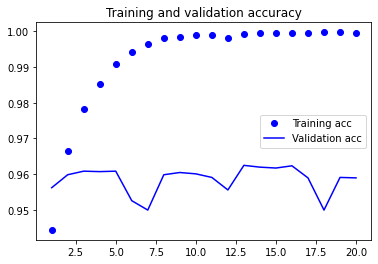

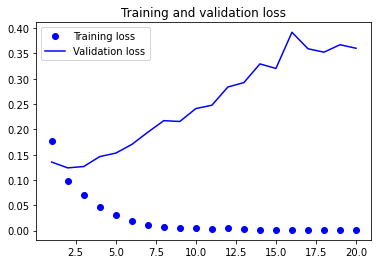

In [6]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [7]:
txt= 'bad tweet'
toke = Tokenizer(num_words = max_words)
toke.fit_on_texts([txt])
one_hotted = toke.texts_to_matrix([txt], mode = 'binary')
print(model.predict(one_hotted))
print(one_hotted, len(one_hotted[0]))
print(word_index['good'], word_index['tweet'], word_index['bad'])

[[0.02037215]]
[[0. 1. 1. ... 0. 0. 0.]] 10000
58 515 301


In [8]:
t = 'bad'
print(word_index['bad'], word_index['the'])
one_2 = tokenizer.texts_to_matrix([t], mode = 'binary')
print(one_2)
print(model.predict(one_2))

301 2
[[0. 0. 0. ... 0. 0. 0.]]
[[0.03032178]]


**lets use embedding layer (glove)**

In [9]:
# reading glove data
import numpy as np

embedding_index = {}

f = open('/content/glove.6B.50d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embedding_index[word] = coefs
f.close()

In [10]:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))

for word,i in word_index.items():
  if i < max_words and word in embedding_index:
    embedding_matrix[i] = embedding_index[word]

In [11]:
from tensorflow.keras.layers import Embedding, Flatten, Dense

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length = 10000))
model2.add(Flatten())
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(32, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

model2.compile(optimizer = 'rmsprop',
               loss = 'binary_crossentropy',
               metrics = ['acc'])

history2 = model2.fit(train_data, train_label,
                    epochs = 10,
                    batch_size = 200 ,
                    validation_data = (val_data, val_label))

Epoch 1/10
120/120 [==============================] - 107s 891ms/step - loss: 0.1676 - acc: 0.9451 - val_loss: 0.1305 - val_acc: 0.9592
Epoch 2/10
120/120 [==============================] - 106s 881ms/step - loss: 0.0811 - acc: 0.9727 - val_loss: 0.1295 - val_acc: 0.9613
Epoch 3/10
120/120 [==============================] - 105s 878ms/step - loss: 0.0393 - acc: 0.9872 - val_loss: 0.1728 - val_acc: 0.9628
Epoch 4/10
120/120 [==============================] - 106s 884ms/step - loss: 0.0171 - acc: 0.9947 - val_loss: 0.1794 - val_acc: 0.9606
Epoch 5/10
120/120 [==============================] - 105s 878ms/step - loss: 0.0068 - acc: 0.9980 - val_loss: 0.2296 - val_acc: 0.9622
Epoch 6/10
120/120 [==============================] - 106s 882ms/step - loss: 0.0047 - acc: 0.9986 - val_loss: 0.2367 - val_acc: 0.9611
Epoch 7/10
120/120 [==============================] - 105s 879ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.3969 - val_acc: 0.9611
Epoch 8/10
120/120 [============================

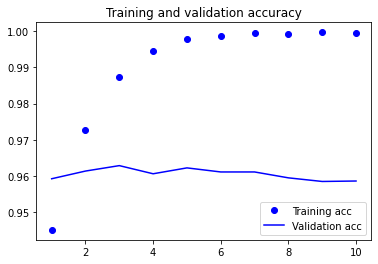

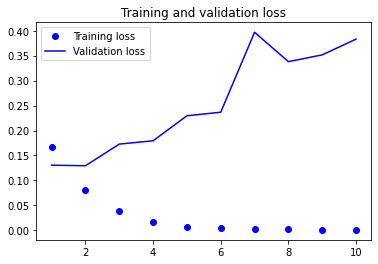

In [12]:
import matplotlib.pyplot as plt
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_words = 10000
max_len = 100

texts= ['men and women']
one_hot_1 = tokenizer.texts_to_matrix(texts, mode = 'binary')
print(one_hot_1)
print(model2.predict(one_hot_1)[0][0])

if model2.predict(one_hot_1)[0][0] > 0.5:
  print('1')
else:
  print('0')

[[0. 0. 0. ... 0. 0. 0.]]
0.9999985
1


In [30]:
import pandas as pd
import numpy as np

test_path = 'https://github.com/ashishsingh101/datasets/blob/main/test_tweets_anuFYb8.csv?raw=true'
test_df = pd.read_csv(test_path)

id = []
ans = []
for i in range(len(test_df)):
  id.append(test_df.iloc[i]['id'])
  tweet_text = [test_df.iloc[i]['tweet']]
  one_hot_tweet = tokenizer.texts_to_matrix(tweet_text, mode = 'binary')
  if model2.predict(one_hot_tweet)[0][0] > 0.5:
    ans.append(1)
  else:
    ans.append(0)

print(id[0], ans[0])



31963 0


In [31]:
dic = {'id':id, 'label':ans}
df = pd.DataFrame(dic)
df.to_csv('/content/sample_data/twitter_analysis_ans.csv')

**save models**